## 1. Continuous Montain Car environment
### Some notes beforehand
* Continuous Mountain Car is an episodic task with continuous control.
* Orignially implemented a 3-layer feed forward neural network in Tensorflow with relu activation function. Actions are sampled from a paramterized gaussian distribution, whose mean and log-variance are learned by seperate neural nets. Value function is also parameterized by a neural network.
* In experiments, however, only a 1 layer MDP is actually used for solving the mountain car task. From empirical observations, excessive layers and non-linearity is unstable and may diverge to infinity. Eligibility trace is integrated into the network.
* The algorithm employed in this assignment is almost exactly identical to that in Sutton's textbook, except for the $\quad I\leftarrow \gamma I \quad$ in trace update is ditched in pratice. There are some other 'minor' changes: 
  1. adding an entropy loss in addition to the $-ln\pi (A|S,\theta)$ when training the actor.
  2. the use of scaler and featurizer to normalize and enrich the original observation.
  3. clipping sampled action value with the range of action_space limits.

In [44]:
! pip install gym
! pip install matplotlib
! pip install scikit-learn

## 2. Actor Critic policy gradient algorithm with trace vectors

In [0]:
import tensorflow as tf
import numpy as np
import gym
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler
import matplotlib.pyplot as plt


class Policy:

    def __init__(self, obs_dim, act_dim, action_space, discount=0.99, lamb=0.8):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.action_space = action_space
        self.discount = discount
        self.lamb = lamb
        self.epochs = 20  # unused when eligibility trace is active
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn_mu()
            self._policy_nn_sigma()
            self._log_prob()
            self._sample()
            self._trace_init()
            self._loss()
            self._trace()
            self._train()
            self.init = tf.global_variables_initializer()

    def _placeholders(self):
        '''
        Add placeholders to the graph
        :return:
        '''
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.advantages_ph = tf.placeholder(tf.float32, (1,), 'advantage')  # number of time steps, usually
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')

    def _policy_nn_mu(self):
        units = self.obs_dim * 10
        # out = tf.layers.dense(self.obs_ph, units,
        #                       kernel_initializer=tf.random_normal_initializer(
        #                           stddev=np.sqrt(1 / self.obs_dim)),
        #                       name = 'dense_mu_1')
        # out = tf.layers.dense(out, units,
        #                       kernel_initializer=tf.random_normal_initializer(
        #                           stddev=np.sqrt(1 / units)),name='dense_mu_2')
        out = tf.layers.dense(self.obs_ph, self.act_dim,
                              kernel_initializer=tf.random_normal_initializer(
                                  stddev=np.sqrt(1 / self.obs_dim)),
                              name='output_mu')
        self.means = out # tf.Print(out, [out], message='Mean: ', summarize=100)

    def _policy_nn_sigma(self):
        units = self.obs_dim * 10
        # out = tf.layers.dense(self.obs_ph, units,
        #                       kernel_initializer=tf.random_normal_initializer(
        #                           stddev=np.sqrt(1 / self.obs_dim)),
        #                       name='dense_sigma_1')
        # out = tf.layers.dense(out, units,
        #                       kernel_initializer=tf.random_normal_initializer(
        #                           stddev=np.sqrt(1 / units)), name='dense_sigma_2')
        out = tf.layers.dense(self.obs_ph, self.act_dim,
                              kernel_initializer=tf.random_normal_initializer(
                                  stddev=np.sqrt(1 / self.obs_dim)),
                              name='output_sigma')
        # assuming a diagonal covariance for the multi-variate gaussian distributionlogvar_speed = (10 * hid3_size) // 48
        self.log_vars = out

        # self.log_vars = tf.get_variable('variance', (self.act_dim), tf.float32)
        # self.log_vars = tf.Print(self.log_vars, [self.log_vars], message='log var: ')

    def _log_prob(self):
        # add time dim to log_var?
        self.logp = -0.5 * (tf.reduce_sum(self.log_vars) + self.act_dim*tf.log(2*np.pi))  # probability of a trajectory
        self.logp += -0.5 * tf.reduce_sum(tf.square(self.act_ph - self.means) /
                                          tf.exp(self.log_vars), axis=1)

    def _sample(self):
        self.sample = self.means + tf.exp(self.log_vars / 2.0) * \
                       tf.random_normal(shape=(self.act_dim,))
#         self.sample = tf.clip_by_value(self.sample, self.action_space.low[0], self.action_space.high[0])
        # self.sample = tf.reshape(self.sample,(self.act_dim,))

    def _trace_init(self):
        """
        Initialize the trace vector; same structure with the gradients
        :return:
        """
        tvs = tf.trainable_variables()
        self.trace = [(tf.Variable(tf.zeros_like(tv), trainable=False)) for tv in tvs]
        self.identity = tf.Variable(1.0, trainable = False, name='identity')
        # reset ops
        self.trace_zero = [self.trace[i].assign(tf.zeros_like(tv)) for i, tv in enumerate(tvs)]
        self.identity_init = [self.identity.assign(1.0)]

    def _loss(self):
        self.loss = -self.logp
        self.loss -= 0.5 * (self.act_dim * (np.log(2 * np.pi) + 1) +
                              tf.reduce_sum(self.log_vars))
        # self.loss -= 1e-1 * self.normal_dist.entropy()

    def _trace(self):
        self.optimizer = tf.train.AdamOptimizer(1e-2)
        self.grads = self.optimizer.compute_gradients(self.loss, tf.trainable_variables())
        self.identity_update = [self.identity.assign(self.identity*self.discount)]
        # self.identity = tf.Print(self.identity, [self.identity], message ='identity: ')
        self.trace_update = [self.trace[i].assign(self.discount * self.lamb * self.trace[i] + self.identity * grad[0]) for i, grad in
                             enumerate(self.grads)]

    def _train(self):
        self.train = self.optimizer.apply_gradients(
            [(self.trace[i] *self.advantages_ph, grad[1]) for i, grad in enumerate(self.grads)])
        # self.train = self.optimizer.apply_gradients(self.trace*self.advantages_ph)
        # self.loss = -self.advantages_ph*self.trace
        # optimizer = tf.train.AdamOptimizer(0.01)
        # self.train = optimizer.minimize(self.loss)

    def _init_session(self):
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def get_sample(self, obs):
        feed_dict = {self.obs_ph: obs}
        return self.sess.run(self.sample, feed_dict=feed_dict)

    def update(self, observes, actions, advantages):
        feed_dict = {self.obs_ph: observes,
                     self.act_ph: actions,
                     self.advantages_ph: advantages
                     }
        self.sess.run(self.trace_update, feed_dict)
        # self.sess.run(self.identity_update)
        self.sess.run([self.train,self.loss], feed_dict)

    def close_sess(self):
        self.sess.close()


class ValueFunc:
    def __init__(self, obs_dim, discount=0.99, lamb=0.8):
        self.obs_dim = obs_dim
        self.epochs = 10
        self.discount = discount
        self.lamb = lamb
        self._build_graph()
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs_ph')
            self.advantages_ph = tf.placeholder(tf.float32, (None,), 'advantages_ph')

            units = self.obs_dim * 10
            # out = tf.layers.dense(self.obs_ph, units, tf.nn.relu,
            #                       kernel_initializer=tf.random_normal_initializer(
            #                         stddev=np.sqrt(1 / self.obs_dim)),
            #                       name="valfunc_d1")
            # out = tf.layers.dense(out, units,
            #                       kernel_initializer=tf.random_normal_initializer(
            #                           stddev=np.sqrt(1 / units)),
            #                       name="valfunc_d2")
            out = tf.layers.dense(self.obs_ph, 1,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=np.sqrt(1 / self.obs_dim)),
                                  name='output')
            # out = tf.Print(out, [out], message='out: ')
            self.out = tf.squeeze(out)  # remove dimensions of size 1 from the shape
            # self.out = tf.Print(out, [out], message='value prediction: ')
            # gradient ascent
            self.loss = -self.out
            # initialize trace
            tvs = tf.trainable_variables()
            self.trace = [(tf.Variable(tf.zeros_like(tv), trainable=False)) for tv in tvs]
            self.identity = tf.Variable(1.0, trainable=False, name='identity')
            # reset ops
            self.trace_zero = [self.trace[i].assign(tf.zeros_like(tv)) for i, tv in enumerate(tvs)]
            self.identity_init = [self.identity.assign(1.0)]

            self.optimizer = tf.train.AdamOptimizer(1e-2)
            self.grads = self.optimizer.compute_gradients(self.loss, tf.trainable_variables())
            self.identity_update = [self.identity.assign(self.identity*self.discount)]
            self.trace_update = [self.trace[i].assign(self.discount * self.lamb * self.trace[i] + grad[0]) for i, grad
                                 in enumerate(self.grads)]

            self.train = self.optimizer.apply_gradients(
                [(self.trace[i] * self.advantages_ph, grad[1]) for i, grad in enumerate(self.grads)])
            self.init = tf.global_variables_initializer()
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def update(self, observes, advantages):
        feed_dict = {self.obs_ph: observes,
                     self.advantages_ph: advantages
                     }

        self.sess.run(self.trace_update, feed_dict)
        # self.sess.run(self.identity_update)
        self.sess.run([self.train, self.loss], feed_dict)

    def predict(self, obs):
        feed_dict = {self.obs_ph: obs}
        val = self.sess.run(self.out, feed_dict=feed_dict)
        return np.squeeze(val)

    def close_sess(self):
        self.sess.close()

class Experiment:

    def __init__(self, env_name, discount=0.99):
        self.env = gym.make(env_name)
        self.obs_dim = 400 #self.env.observation_space.shape[0]
        self.act_dim = self.env.action_space.shape[0]
        self.discount = discount
        self.policy = Policy(self.obs_dim, self.act_dim, self.env.action_space)
        self.value_func = ValueFunc(self.obs_dim)

        print('observation dimension:', self.obs_dim)
        print('action dimension:', self.act_dim)

        # featurizer!
        observation_examples = np.array([self.env.observation_space.sample() for x in range(10000)])
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(observation_examples)

        self.featurizer = sklearn.pipeline.FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
        self.featurizer.fit(self.scaler.transform(observation_examples))

    def featurize_obs(self, obs):
        """
           Returns the featurized representation for a state.
        """
        scaled = None
        try:
            scaled = self.scaler.transform([obs])
        except ValueError:
            pass
        featurized = self.featurizer.transform(scaled)
        return featurized[0]

    def run_one_epsisode(self):
        obs = self.env.reset()
        obs = self.featurize_obs(obs)
        obs = obs.astype(np.float64).reshape((1, -1))
        observes, actions, rewards = [], [], []
        done = False
        step = 0
        while not done:
            # self.env.render()
            # observes.append(obs)

            # print('samping')
            action = self.policy.get_sample(obs).reshape((1, -1)).astype(np.float64)
            # print('action', action)
            # actions.append(action)

            obs_new, reward, done, _ = self.env.step(action)
            obs_new = obs_new.astype(np.float64).reshape((-1,))  # major mistake solved here
            obs_new = self.featurize_obs(obs_new)
            obs_new = obs_new.astype(np.float64).reshape((1, -1))

            if not isinstance(reward, float):
                reward = np.asscalar(reward)
            rewards.append(reward)

            # print('computing advantage')
            advantage = reward + self.discount * self.value_func.predict(obs_new) - self.value_func.predict(obs)
            advantage = advantage.astype(np.float64).reshape((1,))

            # print('advantage', advantage)

            # print('policy update')
            self.policy.update(obs, action, advantage)
            # print('value function update')
            self.value_func.update(obs, advantage)

            obs = obs_new
            step += 0.001

        return observes, actions, rewards

### small experiment, 100 episodes, using discount factor 0.99 and lambda decay 0.8 (same for policy estimator and value function estimator).

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation dimension: 400
action dimension: 1
episode:  0
total steps: 999, episode_reward: -74.70324408958805
episode:  1
total steps: 115, episode_reward: 90.05853125653711
episode:  2
total steps: 243, episode_reward: 79.73233043171363
episode:  3
total steps: 202, episode_reward: 82.05336153525876
episode:  4
total steps: 206, episode_reward: 82.772700134434
episode:  5
total steps: 203, episode_reward: 81.8840236571281
episode:  6
total steps: 280, episode_reward: 76.43390577876423
episode:  7
total steps: 288, episode_reward: 76.45012234973045
episode:  8
total steps: 191, episode_reward: 84.42779625545703
episode:  9
total steps: 383, episode_reward: 67.77841529068748
episode:  10
total steps: 311, episode_reward: 73.60116545393895
episode:  11
total steps: 284, episode_reward: 76.14

total steps: 198, episode_reward: 84.79749521237495
episode:  51
total steps: 312, episode_reward: 73.41821832697923
episode:  52
total steps: 165, episode_reward: 86.88670161953995
episode:  53
total steps: 265, episode_reward: 77.99172808006024
episode:  54
total steps: 304, episode_reward: 75.34037708478942
episode:  55
total steps: 211, episode_reward: 81.92285931486356
episode:  56
total steps: 353, episode_reward: 71.77209934603721
episode:  57
total steps: 209, episode_reward: 83.18513539619288
episode:  58
total steps: 306, episode_reward: 74.51828430729628
episode:  59
total steps: 189, episode_reward: 85.21763605774034
episode:  60
total steps: 339, episode_reward: 71.2874701731774
episode:  61
total steps: 392, episode_reward: 67.92047394183435
episode:  62
total steps: 279, episode_reward: 77.12843950192934
episode:  63
total steps: 222, episode_reward: 81.24138723150037
episode:  64
total steps: 305, episode_reward: 74.6455231003774
episode:  65
total steps: 196, episode_r

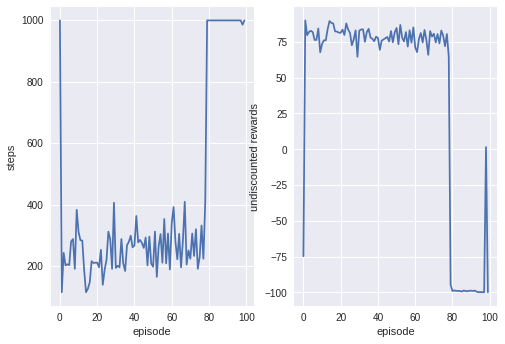

In [5]:
# network too big will explode!!
env = Experiment('MountainCarContinuous-v0')
steps = []
undiscounted = []
# 100 episodes
for i in range(100):
    # trace vectors are emptied at the beginning of each episode
    env.policy.sess.run(env.policy.trace_zero)
    env.policy.sess.run(env.policy.identity_init)
    env.value_func.sess.run(env.value_func.trace_zero)
    env.value_func.sess.run(env.value_func.identity_init)

    print('episode: ', i)
    _, _, rewards = env.run_one_epsisode()
    total_steps = len(rewards)
    print('total steps: {0}, episode_reward: {1}'.format(total_steps, np.sum(rewards)))
    steps.append(total_steps)
    undiscounted.append(np.sum(rewards))

plt.subplot(121)
plt.xlabel('episode')
plt.ylabel('steps')
plt.plot(steps)

plt.subplot(122)
plt.xlabel('episode')
plt.ylabel('undiscounted rewards')
plt.plot(undiscounted)

* Requirement for solving this task is to have a reward over 90.0 in at least 100 consecutive episodes.
* Initialization of the policy is vital to the success of this task. It may happen that the agent get stuck at the bottom in the beginning, therefore having trouble to explore further.

### another experiment, where the outcome is fairly bad, illustrating the importance of policy estimator initialization.

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation dimension: 400
action dimension: 1
episode:  0
total steps: 324, episode_reward: 75.30661268142818
episode:  1
total steps: 133, episode_reward: 90.96028170648164
episode:  2
total steps: 328, episode_reward: 78.02838543143618
episode:  3
total steps: 999, episode_reward: -72.95185802146761
episode:  4
total steps: 999, episode_reward: -98.4637157851412
episode:  5
total steps: 999, episode_reward: -98.57531995000754
episode:  6
total steps: 999, episode_reward: -97.3525267907591
episode:  7
total steps: 999, episode_reward: -98.40880658203235
episode:  8
total steps: 999, episode_reward: -96.96115141893785
episode:  9
total steps: 999, episode_reward: -98.15037590883617
episode:  10
total steps: 999, episode_reward: -97.56629157581783
episode:  11
total steps: 999, episode_rewar

total steps: 999, episode_reward: -99.64590016144585
episode:  53
total steps: 999, episode_reward: -99.79601566525017
episode:  54
total steps: 999, episode_reward: -99.79929922067615
episode:  55
total steps: 999, episode_reward: -99.8261507753713
episode:  56
total steps: 999, episode_reward: -99.72854067101262
episode:  57
total steps: 999, episode_reward: -99.9
episode:  58
total steps: 999, episode_reward: -99.9
episode:  59
total steps: 999, episode_reward: -99.9
episode:  60
total steps: 999, episode_reward: -99.9
episode:  61
total steps: 999, episode_reward: -99.9
episode:  62
total steps: 999, episode_reward: -99.9
episode:  63
total steps: 999, episode_reward: -99.9
episode:  64
total steps: 999, episode_reward: -99.9
episode:  65
total steps: 999, episode_reward: -99.9
episode:  66
total steps: 999, episode_reward: -99.9
episode:  67
total steps: 999, episode_reward: -99.9
episode:  68
total steps: 999, episode_reward: -99.9
episode:  69
total steps: 999, episode_reward: -

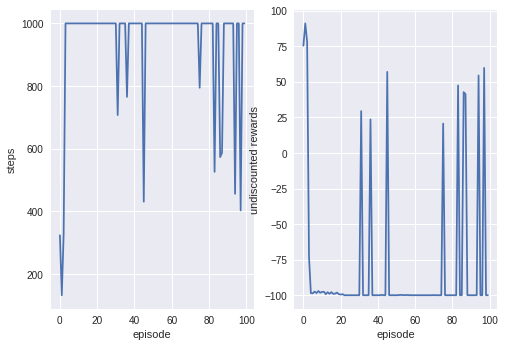

In [6]:
env = Experiment('MountainCarContinuous-v0')
steps = []
undiscounted = []
# 100 episodes
for i in range(100):
    # trace vectors are emptied at the beginning of each episode
    env.policy.sess.run(env.policy.trace_zero)
    env.policy.sess.run(env.policy.identity_init)
    env.value_func.sess.run(env.value_func.trace_zero)
    env.value_func.sess.run(env.value_func.identity_init)

    print('episode: ', i)
    _, _, rewards = env.run_one_epsisode()
    total_steps = len(rewards)
    print('total steps: {0}, episode_reward: {1}'.format(total_steps, np.sum(rewards)))
    steps.append(total_steps)
    undiscounted.append(np.sum(rewards))

plt.subplot(121)
plt.xlabel('episode')
plt.ylabel('steps')
plt.plot(steps)

plt.subplot(122)
plt.xlabel('episode')
plt.ylabel('undiscounted rewards')
plt.plot(undiscounted)

This picture shows that the agent may have trouble learning the policy.

## (3. two-layers FNN with relu activation function)


In [0]:
class NonlinearPolicy:
  
    def __init__(self, obs_dim, act_dim, action_space, discount=0.99, lamb=0.8):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.action_space = action_space
        self.discount = discount
        self.lamb = lamb
        self.epochs = 20  # unused when eligibility trace is active
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn_mu()
            self._policy_nn_sigma()
            self._log_prob()
            self._sample()
            self._trace_init()
            self._loss()
            self._trace()
            self._train()
            self.init = tf.global_variables_initializer()

    def _placeholders(self):
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.advantages_ph = tf.placeholder(tf.float32, (1,), 'advantage')  # number of time steps, usually
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')

    def _policy_nn_mu(self):
        units = self.obs_dim * 10
        out = tf.layers.dense(self.obs_ph, units, tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(
                                  stddev=np.sqrt(1 / self.obs_dim)),
                              name = 'dense_mu_1')
        out = tf.layers.dense(out, self.act_dim,
                              kernel_initializer=tf.random_normal_initializer(
                                  stddev=np.sqrt(1 / self.obs_dim)),
                              name='output_mu')
        self.means = out

    def _policy_nn_sigma(self):
        units = self.obs_dim * 10
        out = tf.layers.dense(self.obs_ph, units, tf.nn.relu,
                              kernel_initializer=tf.random_normal_initializer(
                                  stddev=np.sqrt(1 / self.obs_dim)),
                              name='dense_sigma_1')
        out = tf.layers.dense(out, self.act_dim,
                              kernel_initializer=tf.random_normal_initializer(
                                  stddev=np.sqrt(1 / self.obs_dim)),
                              name='output_sigma')
        
        # assuming a diagonal covariance for the multi-variate gaussian distributionlogvar_speed = (10 * hid3_size) // 48
        self.log_vars = out

    def _log_prob(self):
        self.logp = -0.5 * (tf.reduce_sum(self.log_vars) + self.act_dim*tf.log(2*np.pi))  # probability of a trajectory
        self.logp += -0.5 * tf.reduce_sum(tf.square(self.act_ph - self.means) /
                                          tf.exp(self.log_vars), axis=1)

    def _sample(self):
        self.sample = self.means + tf.exp(self.log_vars / 2.0) * \
                       tf.random_normal(shape=(self.act_dim,))
        self.sample = tf.clip_by_value(self.sample, self.action_space.low[0], self.action_space.high[0])

    def _trace_init(self):
        tvs = tf.trainable_variables()
        self.trace = [(tf.Variable(tf.zeros_like(tv), trainable=False)) for tv in tvs]
        # reset ops
        self.trace_zero = [self.trace[i].assign(tf.zeros_like(tv)) for i, tv in enumerate(tvs)]

    def _loss(self):
        self.loss = -self.logp
        self.loss -= 0.5 * (self.act_dim * (np.log(2 * np.pi) + 1) +
                              tf.reduce_sum(self.log_vars))

    def _trace(self):
        self.optimizer = tf.train.AdamOptimizer(1e-2)
        self.grads = self.optimizer.compute_gradients(self.loss, tf.trainable_variables())
        self.trace_update = [self.trace[i].assign(self.discount * self.lamb * self.trace[i] + grad[0]) for i, grad in
                             enumerate(self.grads)]

    def _train(self):
        self.train = self.optimizer.apply_gradients(
            [(self.trace[i] * self.advantages_ph, grad[1]) for i, grad in enumerate(self.grads)])

    def _init_session(self):
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def get_sample(self, obs):
        feed_dict = {self.obs_ph: obs}
        return self.sess.run(self.sample, feed_dict=feed_dict)

    def update(self, observes, actions, advantages):
        feed_dict = {self.obs_ph: observes,
                     self.act_ph: actions,
                     self.advantages_ph: advantages
                     }
        self.sess.run(self.trace_update, feed_dict)
        self.sess.run([self.train, self.loss], feed_dict)

    def close_sess(self):
        self.sess.close()
        
        
class NonlinearValueFunc:
  
    def __init__(self, obs_dim, discount=0.99, lamb=0.8):
        self.obs_dim = obs_dim
        self.epochs = 10
        self.discount = discount
        self.lamb = lamb
        self._build_graph()
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs_ph')
            self.advantages_ph = tf.placeholder(tf.float32, (None,), 'advantages_ph')

            units = self.obs_dim * 10
            out = tf.layers.dense(self.obs_ph, units, tf.nn.relu,
                                  kernel_initializer=tf.random_normal_initializer(
                                    stddev=np.sqrt(1 / self.obs_dim)),
                                  name="valfunc_d1")
            out = tf.layers.dense(out, 1,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=np.sqrt(1 / self.obs_dim)),
                                  name='output')
            self.out = tf.squeeze(out)
            # gradient ascent
            self.loss = -self.out
            # initialize trace
            tvs = tf.trainable_variables()
            self.trace = [(tf.Variable(tf.zeros_like(tv), trainable=False)) for tv in tvs]
            # reset ops
            self.trace_zero = [self.trace[i].assign(tf.zeros_like(tv)) for i, tv in enumerate(tvs)]

            self.optimizer = tf.train.AdamOptimizer(1e-2)
            self.grads = self.optimizer.compute_gradients(self.loss, tf.trainable_variables())
            self.trace_update = [self.trace[i].assign(self.discount * self.lamb * self.trace[i] + grad[0]) for i, grad
                                 in enumerate(self.grads)]

            self.train = self.optimizer.apply_gradients(
                [(self.trace[i] * self.advantages_ph, grad[1]) for i, grad in enumerate(self.grads)])
            self.init = tf.global_variables_initializer()
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def update(self, observes, advantages):
        feed_dict = {self.obs_ph: observes,
                     self.advantages_ph: advantages
                     }

        self.sess.run(self.trace_update, feed_dict)
        self.sess.run([self.train, self.loss], feed_dict)

    def predict(self, obs):
        feed_dict = {self.obs_ph: obs}
        val = self.sess.run(self.out, feed_dict=feed_dict)
        return np.squeeze(val)

    def close_sess(self):
        self.sess.close()

class NonlinearExperiment:

    def __init__(self, env_name, discount=0.99):
        self.env = gym.make(env_name)
        self.obs_dim = 401 # add time dimension
        self.act_dim = self.env.action_space.shape[0]
        self.discount = discount
        self.policy = NonlinearPolicy(self.obs_dim, self.act_dim, self.env.action_space)
        self.value_func = NonlinearValueFunc(self.obs_dim)

        print('observation dimension:', self.obs_dim)
        print('action dimension:', self.act_dim)

        observation_examples = np.array([self.env.observation_space.sample() for x in range(10000)])
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(observation_examples)

        self.featurizer = sklearn.pipeline.FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
        self.featurizer.fit(self.scaler.transform(observation_examples))

    def featurize_obs(self, obs):
        scaled = None
        try:
            scaled = self.scaler.transform([obs])
        except ValueError:
            pass
        featurized = self.featurizer.transform(scaled)
        return featurized[0]

    def run_one_epsisode(self):
        obs = self.env.reset()
        step = 0
        obs = self.featurize_obs(obs)
        obs = np.append(obs, [step], axis=0)
        obs = obs.astype(np.float64).reshape((1, -1))
        observes, actions, rewards = [], [], []
        done = False
        while not done:
            step += 0.001
            action = self.policy.get_sample(obs).reshape((1, -1)).astype(np.float64)

            obs_new, reward, done, _ = self.env.step(action)
            obs_new = obs_new.astype(np.float64).reshape((-1,))
            obs_new = self.featurize_obs(obs_new)
            obs_new = np.append(obs_new, [step], axis=0)
            obs_new = obs_new.astype(np.float64).reshape((1, -1))

            if not isinstance(reward, float):
                reward = np.asscalar(reward)
            rewards.append(reward)

            advantage = reward + self.discount * self.value_func.predict(obs_new) - self.value_func.predict(obs)
            advantage = advantage.astype(np.float64).reshape((1,))

            self.policy.update(obs, action, advantage)
            self.value_func.update(obs, advantage)

            obs = obs_new
        return observes, actions, rewards

### Nonlinear method is quite slow. We stop evaluating it, since it isn't prone to yield any conspicuous improvement.
We move on to evaluate the variant algorithms.

## 3. Variant algorithms

In [0]:
class NonTracePolicy:
  
    def __init__(self, obs_dim, act_dim, action_space, discount=0.99, lamb=0.8):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.action_space = action_space
        self.discount = discount
        self.lamb = lamb
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn_mu()
            self._policy_nn_sigma()
            self._log_prob()
            self._sample()
            self._loss()
            self._train()
            self.init = tf.global_variables_initializer()

    def _placeholders(self):
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.advantages_ph = tf.placeholder(tf.float32, (1,), 'advantage')  # number of time steps, usually
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')

    def _policy_nn_mu(self):
        out = tf.layers.dense(self.obs_ph, self.act_dim,
                              kernel_initializer=tf.random_normal_initializer(
                                  stddev=np.sqrt(1 / self.obs_dim)),
                              name='output_mu')
        self.means = out

    def _policy_nn_sigma(self):
        out = tf.layers.dense(self.obs_ph, self.act_dim,
                              kernel_initializer=tf.random_normal_initializer(
                                  stddev=np.sqrt(1 / self.obs_dim)),
                              name='output_sigma')
        
        # assuming a diagonal covariance for the multi-variate gaussian distribution
        self.log_vars = out

    def _log_prob(self):
        self.logp = -0.5 * (tf.reduce_sum(self.log_vars))  # probability of a trajectory
        self.logp += -0.5 * tf.reduce_sum(tf.square(self.act_ph - self.means) /
                                          tf.exp(self.log_vars), axis=1)

    def _sample(self):
        self.sample = self.means + tf.exp(self.log_vars / 2.0) * \
                       tf.random_normal(shape=(self.act_dim,))
#         self.sample = tf.clip_by_value(self.sample, self.action_space.low[0], self.action_space.high[0])


    def _loss(self):
        self.loss = -self.logp
        self.loss -= 0.5 * (self.act_dim * (np.log(2 * np.pi) + 1) +
                              tf.reduce_sum(self.log_vars))
        self.loss *= self.advantages_ph

    def _train(self):
        # fixed learning rate: we can do better than that by being adaptive 
        self.optimizer = tf.train.AdamOptimizer(1e-3)
        self.train = self.optimizer.minimize(self.loss)

    def _init_session(self):
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def get_sample(self, obs):
        feed_dict = {self.obs_ph: obs}
        return self.sess.run(self.sample, feed_dict=feed_dict)

    def update(self, observes, actions, advantages):
        feed_dict = {self.obs_ph: observes,
                     self.act_ph: actions,
                     self.advantages_ph: advantages
                     }
        self.sess.run([self.train, self.loss], feed_dict)

    def close_sess(self):
        self.sess.close()
        
        
class NonTraceValueFunc:
  
    def __init__(self, obs_dim, discount=0.99, lamb=0.8):
        self.obs_dim = obs_dim
        self.epochs = 10
        self.discount = discount
        self.lamb = lamb
        self._build_graph()
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs_ph')
            self.advantages_ph = tf.placeholder(tf.float32, (None,), 'advantages_ph')

            units = self.obs_dim * 10
            out = tf.layers.dense(self.obs_ph, 1,
                                  kernel_initializer=tf.random_normal_initializer(
                                      stddev=np.sqrt(1 / self.obs_dim)),
                                  name='output')
            self.out = tf.squeeze(out)
            # gradient ascent
            self.loss = -self.out*self.advantages_ph

            self.optimizer = tf.train.AdamOptimizer(1e-2)
            self.train = self.optimizer.minimize(self.loss)
            
            self.init = tf.global_variables_initializer()
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def update(self, observes, advantages):
        feed_dict = {self.obs_ph: observes,
                     self.advantages_ph: advantages
                     }
        
        self.sess.run([self.train, self.loss], feed_dict)

    def predict(self, obs):
        feed_dict = {self.obs_ph: obs}
        val = self.sess.run(self.out, feed_dict=feed_dict)
        return np.squeeze(val)

    def close_sess(self):
        self.sess.close()

class VariantExperiment:

    def __init__(self, env_name, policy, value_func, discount=0.99):
        self.env = gym.make(env_name)
        self.obs_dim = 400
        self.act_dim = self.env.action_space.shape[0]
        self.discount = discount
        self.policy = policy
        self.value_func = value_func

        print('observation dimension:', self.obs_dim)
        print('action dimension:', self.act_dim)

        observation_examples = np.array([self.env.observation_space.sample() for x in range(10000)])
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(observation_examples)

        self.featurizer = sklearn.pipeline.FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
        self.featurizer.fit(self.scaler.transform(observation_examples))

    def featurize_obs(self, obs):
        scaled = None
        featurized = None
        try:
            scaled = self.scaler.transform([obs])
            featurized = self.featurizer.transform(scaled)
        except ValueError:
            print(obs)
            print(scaled)
        return featurized[0]

    def run_one_epsisode(self):
        obs = self.env.reset()
        obs = self.featurize_obs(obs)
        obs = obs.astype(np.float64).reshape((1, -1))
        rewards = []
        done = False
        while not done:
            action = self.policy.get_sample(obs).reshape((1, -1)).astype(np.float64)

            obs_new, reward, done, _ = self.env.step(action)
            obs_new = obs_new.astype(np.float64).reshape((-1,))
            obs_new = self.featurize_obs(obs_new)
            obs_new = obs_new.astype(np.float64).reshape((1, -1))

            if not isinstance(reward, float):
                reward = np.asscalar(reward)
            rewards.append(reward)

            advantage = reward + self.discount * self.value_func.predict(obs_new) - self.value_func.predict(obs)
            advantage = advantage.astype(np.float64).reshape((1,))

            self.policy.update(obs, action, advantage)
            self.value_func.update(obs, advantage)

            obs = obs_new
        return rewards

## 3.1 Variant 1: use trace on critic but not actor

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation dimension: 400
action dimension: 1
episode:  0
total steps: 317, episode_reward: 77.30369575365425
episode:  1
total steps: 560, episode_reward: 67.66892293430078
episode:  2
total steps: 226, episode_reward: 89.42893526625492
episode:  3
total steps: 263, episode_reward: 86.61390760528768
episode:  4
total steps: 128, episode_reward: 85.4908937776866
episode:  5
total steps: 130, episode_reward: 81.1580719379853
episode:  6
total steps: 174, episode_reward: 69.63623443055505
episode:  7
total steps: 167, episode_reward: 86.33931929817311
episode:  8
total steps: 137, episode_reward: 70.85508191464348
episode:  9
total steps: 223, episode_reward: 59.92715081739603
episode:  10
total

total steps: 135, episode_reward: 44.84283078077058
episode:  50
total steps: 133, episode_reward: 75.4723296512839
episode:  51
total steps: 131, episode_reward: 75.8188610560074
episode:  52
total steps: 157, episode_reward: 71.6683393454976
episode:  53
total steps: 123, episode_reward: 64.33261622228396
episode:  54
total steps: 132, episode_reward: 57.266936349951216
episode:  55
total steps: 141, episode_reward: 63.91935795467917
episode:  56
total steps: 122, episode_reward: 14.349015117996515
episode:  57
total steps: 126, episode_reward: 75.76806418954283
episode:  58
total steps: 130, episode_reward: 62.64763685242325
episode:  59
total steps: 137, episode_reward: 70.27225116874662
episode:  60
total steps: 123, episode_reward: 28.20605879200133
episode:  61
total steps: 125, episode_reward: 26.678124685744052
episode:  62
total steps: 132, episode_reward: 36.6291709615198
episode:  63
total steps: 126, episode_reward: 53.33021707997937
episode:  64
total steps: 137, episode_

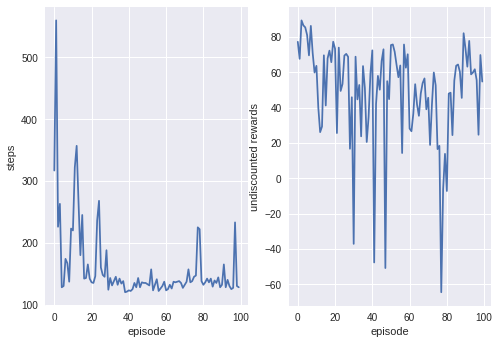

In [36]:
env = VariantExperiment('MountainCarContinuous-v0', 
                        NonTracePolicy(400, 1, gym.spaces.Box(low=-1.0, high=1.0, shape=(1,))), 
                        ValueFunc(400))
steps = []
undiscounted = []
# 100 episodes
for i in range(100):
    env.value_func.sess.run(env.value_func.trace_zero)
    print('episode: ', i)
    rewards = env.run_one_epsisode()
    total_steps = len(rewards)
    print('total steps: {0}, episode_reward: {1}'.format(total_steps, np.sum(rewards)))
    steps.append(total_steps)
    undiscounted.append(np.sum(rewards))

plt.subplot(121)
plt.xlabel('episode')
plt.ylabel('steps')
plt.plot(steps)

plt.subplot(122)
plt.xlabel('episode')
plt.ylabel('undiscounted rewards')
plt.plot(undiscounted)

## 3.2 Variant 2, no traces anywhere at all.

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation dimension: 400
action dimension: 1
episode:  0
total steps: 508, episode_reward: 68.54683764773594
episode:  1
total steps: 381, episode_reward: 83.42094079042612
episode:  2
total steps: 247, episode_reward: 88.10218743568704
episode:  3
total steps: 344, episode_reward: 83.1068385430807
episode:  4
total steps: 482, episode_reward: 73.39372503083003
episode:  5
total steps: 295, episode_reward: 78.27018315606904
episode:  6
total steps: 299, episode_reward: 69.17871085404536
episode:  7
total steps: 229, episode_reward: 81.88983508288985
episode:  8
total steps: 399, episode_reward: 62.14612563696431
episode:  9
total steps: 339, episode_reward: 67.44734882211398
episode:  10
tota

total steps: 156, episode_reward: 22.041685480447505
episode:  50
total steps: 135, episode_reward: 41.280703992088895
episode:  51
total steps: 134, episode_reward: 40.30378004742411
episode:  52
total steps: 143, episode_reward: 23.453365556037575
episode:  53
total steps: 137, episode_reward: 53.6435562498056
episode:  54
total steps: 235, episode_reward: 2.584838211966943
episode:  55
total steps: 246, episode_reward: -5.158152771676377
episode:  56
total steps: 294, episode_reward: -23.291850442859335
episode:  57
total steps: 227, episode_reward: -27.698890670900873
episode:  58
total steps: 999, episode_reward: -718.1138488843478
episode:  59
total steps: 120, episode_reward: 30.767023106866723
episode:  60
total steps: 131, episode_reward: -9.78134089408303
episode:  61
total steps: 129, episode_reward: 63.30062738664711
episode:  62
total steps: 126, episode_reward: 42.217174684887404
episode:  63
total steps: 125, episode_reward: 57.06596393867854
episode:  64
total steps: 13

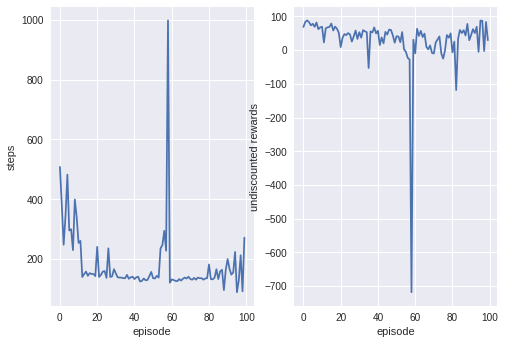

In [37]:
env = VariantExperiment('MountainCarContinuous-v0', 
                        NonTracePolicy(400, 1, gym.spaces.Box(low=-1.0, high=1.0, shape=(1,))), 
                        NonTraceValueFunc(400))
steps = []
undiscounted = []
# 100 episodes
for i in range(100):
    print('episode: ', i)
    rewards = env.run_one_epsisode()
    total_steps = len(rewards)
    print('total steps: {0}, episode_reward: {1}'.format(total_steps, np.sum(rewards)))
    steps.append(total_steps)
    undiscounted.append(np.sum(rewards))

plt.subplot(121)
plt.xlabel('episode')
plt.ylabel('steps')
plt.plot(steps)

plt.subplot(122)
plt.xlabel('episode')
plt.ylabel('undiscounted rewards')
plt.plot(undiscounted)

## 3.3 Some thoughts
For continuous mountain car problem, because the biggest reward(target) is the hardest to reach, so a properly initialized policy network is crucial for the success of an agent.

If not initialized properly, the agent may be dispointed and will learn to do nothing — yielding a total reward close to zero by remaining static at the bottom.

## 4. Comparison experiment
Now we are in a good shape to do a general comparison. $\gamma = 0.99$ has been empirically determined to be the most appropriate discount factor; we will demonstrate the comparison by changing $\lambda$.


### Evaluated in 10 episodes

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation dimension: 400
action dimension: 1
non trace
lambda 0.2
whole trace
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation dimension: 400
action dimension: 1
partial trace
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation dimension: 400
action dimension: 1
lambda 0.4
whole tra

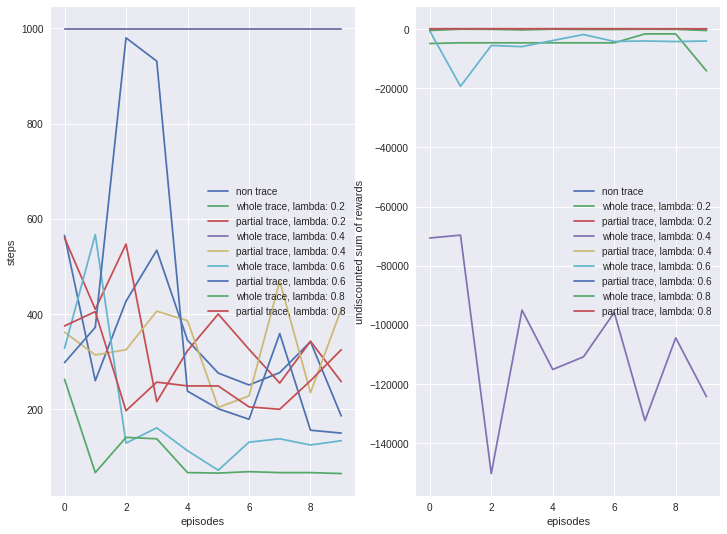

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,9))
ax1.set_xlabel('episodes')
ax2.set_xlabel('episodes')
ax1.set_ylabel('steps')
ax2.set_ylabel('undiscounted sum of rewards')

# evaluated only once, since there is no lambda parameter in it
steps = []
undiscounted = []
env_no_trace = VariantExperiment('MountainCarContinuous-v0',
                        NonTracePolicy(400, 1, gym.spaces.Box(low=-1.0, high=1.0, shape=(1,))), 
                        NonTraceValueFunc(400))
print('non trace')
for i in range(10):
    rewards = env_no_trace.run_one_epsisode()
    total_steps = len(rewards)
    steps.append(total_steps)
    undiscounted.append(np.sum(rewards))
ax1.plot(steps, label='non trace')
ax2.plot(undiscounted, label='non trace')


lamb = [0.2, 0.4, 0.6, 0.8]
for lam in lamb:
  print('lambda', lam)
  print('whole trace')
  steps = []
  undiscounted = []
  env = Experiment('MountainCarContinuous-v0')
  env.policy.lamb = lam
  for i in range(10):
    _,_,rewards = env.run_one_epsisode()
    total_steps = len(rewards)
    steps.append(total_steps)
    undiscounted.append(np.sum(rewards))
#   print(steps)
#   print(undiscounted)
  ax1.plot(steps, label='whole trace, lambda: {}'.format(lam))
  ax2.plot(undiscounted, label='whole trace, lambda: {}'.format(lam))
  
  print('partial trace')
  steps = []
  undiscounted = []
  env = VariantExperiment('MountainCarContinuous-v0', 
                        NonTracePolicy(400, 1, gym.spaces.Box(low=-1.0, high=1.0, shape=(1,))), 
                        ValueFunc(400))
  env.policy.lamb = lam
  for i in range(10):
    rewards = env.run_one_epsisode()
    total_steps = len(rewards)
    steps.append(total_steps)
    undiscounted.append(np.sum(rewards))
  ax1.plot(steps, label='partial trace, lambda: {}'.format(lam))
  ax2.plot(undiscounted, label='partial trace, lambda: {}'.format(lam))
  
  ax1.legend()
  ax2.legend()

Surprisingly, algorithms using eligility trace for both actor and critic are sub-optimal.

### Evaluated in 50 episodes

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation dimension: 400
action dimension: 1
non trace
lambda 0.2
whole trace
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation dimension: 400
action dimension: 1
partial trace
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
observation dimension: 400
action dimension: 1
lambda 0.4
whole tra

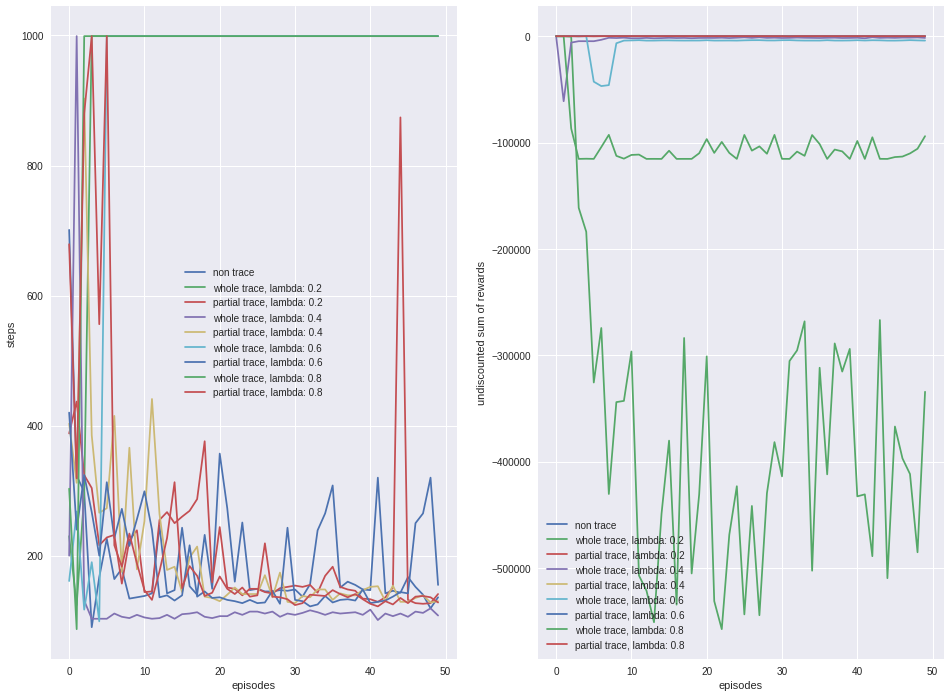

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,12))
ax1.set_xlabel('episodes')
ax2.set_xlabel('episodes')
ax1.set_ylabel('steps')
ax2.set_ylabel('undiscounted sum of rewards')

# evaluated only once, since there is no lambda parameter in it
steps = []
undiscounted = []
env_no_trace = VariantExperiment('MountainCarContinuous-v0',
                        NonTracePolicy(400, 1, gym.spaces.Box(low=-1.0, high=1.0, shape=(1,))), 
                        NonTraceValueFunc(400))
print('non trace')
for i in range(50):
    rewards = env_no_trace.run_one_epsisode()
    total_steps = len(rewards)
    steps.append(total_steps)
    undiscounted.append(np.sum(rewards))
ax1.plot(steps, label='non trace')
ax2.plot(undiscounted, label='non trace')


lamb = [0.2, 0.4, 0.6, 0.8]
for lam in lamb:
  print('lambda', lam)
  print('whole trace')
  steps = []
  undiscounted = []
  env = Experiment('MountainCarContinuous-v0')
  env.policy.lamb = lam
  for i in range(50):
    _,_,rewards = env.run_one_epsisode()
    total_steps = len(rewards)
    steps.append(total_steps)
    undiscounted.append(np.sum(rewards))
#   print(steps)
#   print(undiscounted)
  ax1.plot(steps, label='whole trace, lambda: {}'.format(lam))
  ax2.plot(undiscounted, label='whole trace, lambda: {}'.format(lam))
  
  print('partial trace')
  steps = []
  undiscounted = []
  env = VariantExperiment('MountainCarContinuous-v0', 
                        NonTracePolicy(400, 1, gym.spaces.Box(low=-1.0, high=1.0, shape=(1,))), 
                        ValueFunc(400))
  env.policy.lamb = lam
  for i in range(50):
    rewards = env.run_one_epsisode()
    total_steps = len(rewards)
    steps.append(total_steps)
    undiscounted.append(np.sum(rewards))
  ax1.plot(steps, label='partial trace, lambda: {}'.format(lam))
  ax2.plot(undiscounted, label='partial trace, lambda: {}'.format(lam))
  
  ax1.legend()
  ax2.legend()